# Foreign Exchange Market Analysis

Value-at-Risk (VaR) is an important concept in financial risk management. It is an attempt to get an idea of a probable maximum loss for some confidence level (5%, 1%, etc) within some time frame. Background information can be found on the wikipedia page [here](https://en.wikipedia.org/wiki/Value_at_risk) and another article is found at [Investopedia](https://www.investopedia.com/articles/04/092904.asp). This is a breakdown of the various basic methods to calculating VaR. Most introductions focus on the parametric approach, also called the variance-covariance approach, but I will start with the historical method.

## Import Libraries

In [116]:
import quandl
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib import mlab
import scipy as sc
from math import ceil

In [4]:
with open('../quandl.json') as file:
    json_file = json.load(file)
    api_key = json_file['api_key']
quandl.ApiConfig.api_key = api_key

In [5]:
MMM = quandl.get("WIKI/MMM")

In [30]:
#quandl.get("WIKI/MMM", start_date="2001-12-31", end_date="2005-12-31")

Below are the 30 large companies from the Dow Jones Industrial Average (DJIA) from December 31, 2016 to December 31, 2017. We initialize the data into a pandas dataframe using quandl. The list of components in the Dow Jones Industrial Average has been taken from [here](https://tradingninvestment.com/2017-dow-jones-industrial-average-return-dow-30-return/).

In [126]:
DOW_list_2017 = ["WIKI/MMM","WIKI/AXP","WIKI/AAPL","WIKI/BA","WIKI/CAT","WIKI/CVX","WIKI/CSCO","WIKI/DIS",
"WIKI/DWDP","WIKI/GE","WIKI/GS","WIKI/HD","WIKI/IBM","WIKI/INTC","WIKI/JNJ","WIKI/JPM","WIKI/MCD","WIKI/MRK",
"WIKI/MSFT","WIKI/NKE","WIKI/PFE","WIKI/PG","WIKI/KO","WIKI/TRV","WIKI/UNH","WIKI/UTX","WIKI/VZ","WIKI/V",
"WIKI/WMT","WIKI/XOM"]

In [127]:
DOW = quandl.get(DOW_list_2017, start_date="2016-12-31", end_date="2017-12-31")

In [128]:
DOW_nonull = DOW[DOW['WIKI/MMM - Open'].notnull()]

In [129]:
returns = DOW[list(DOW.columns[DOW.columns.str.contains('Adj. Close')])]

In [130]:
col_dict = {}
# Loop below is used for renaming the columns for readability
for n in returns.columns:
    y = n.split(' - ')
    m, _ = y
    _, z = m.split('/')
    col_dict[n] = z

In [131]:
returns = returns.rename(columns=col_dict)

# Historical Method for Calculating VaR - 3M Company

Here we develop a historical method for calculating the Value at Risk (VaR) for 3M Company. This method simply re-organizes actual historical returns, putting them in order from worst to best. It then assumes that history will repeat itself, from a risk perspective. We will find the most (as well as the range) one can expect to lose with 95% confidence. That means we are looking for the bottom 5% of days with a difference in closing price (relative to previous day).

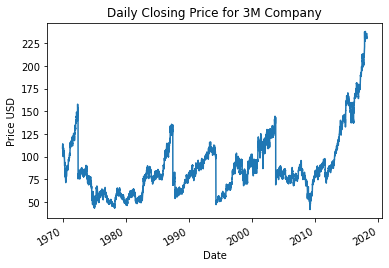

In [137]:
MMM['Close'].plot(kind='line')
plt.title('Daily Closing Price for 3M Company')
plt.xlabel('Date')
plt.ylabel('Price USD');

In [138]:
MMM_diff = MMM['Close'].diff()

Below is a plot of percent change of closing prices, which will be used to find our 5% VaR.

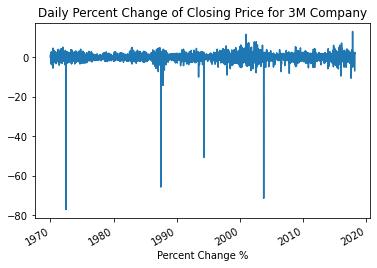

In [139]:
MMM_diff.plot(kind='line')
plt.title('Daily Percent Change of Closing Price for 3M Company')
plt.xlabel('Percent Change %');

Remove Outliers to plot a histogram

In [140]:
tmp_1 = MMM_diff[MMM_diff < -15].count()
tmp_2 = MMM_diff[MMM_diff > 11].count()
print('The number of trading days with percent change less than -15 is {},\n\
The number of trading days with percent change greater than 11 is {}.'.format(tmp_1,tmp_2))

The number of trading days with percent change less than -15 is 4,
The number of trading days with percent change greater than 11 is 2.


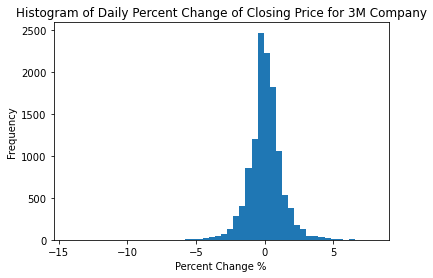

In [306]:
MMM_diff[(MMM_diff > -15) & (MMM_diff < 11)].plot(kind='hist', bins=50)
plt.title('Histogram of Daily Percent Change of Closing Price for 3M Company')
plt.xlabel('Percent Change %');

## One-Day 5% VaR

Now we are looking at the one-day 5% Value at Risk for 3M company.

In [307]:
bot_five = ceil(len(MMM_diff.sort_values())*0.05)
bot_five = MMM_diff.sort_values().head(bot_five)
bot_five.describe()

count    605.000000
mean      -3.220231
std        5.347960
min      -77.120000
25%       -3.100000
50%       -2.460000
75%       -2.100000
max       -1.880000
Name: Close, dtype: float64

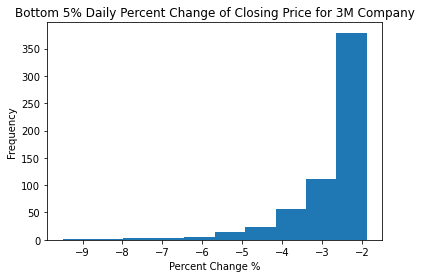

In [308]:
bot_five[bot_five > -10].plot(kind='hist')
plt.title('Bottom 5% Daily Percent Change of Closing Price for 3M Company')
plt.xlabel('Percent Change %');

In [309]:
tmp_1 = round(bot_five.max(),4)
tmp_2 = round(bot_five.min(),4)
print('The minimum daily loss we can expect is {} with 5% confidence\n\
The maximum daily loss we can expect is {} with 5% confidence'.format(tmp_1,tmp_2))

The minimum daily loss we can expect is -1.88 with 5% confidence
The maximum daily loss we can expect is -77.12 with 5% confidence


## 1% VaR

We will now check the one-day 1% Value at Risk for 3M company.

In [310]:
bot_one = ceil(len(MMM_diff.sort_values())*0.01)
bot_one = MMM_diff.sort_values().head(bot_one)
bot_one.describe()

count    121.000000
mean      -6.674876
std       11.326697
min      -77.120000
25%       -5.000000
50%       -4.110000
75%       -3.740000
max       -3.370000
Name: Close, dtype: float64

In [311]:
tmp_1 = round(bot_one.max(),4)
tmp_2 = round(bot_one.min(),4)
print('The minimum daily loss we can expect is {} with 1% confidence\n\
The maximum daily loss we can expect is {} with 1% confidence'.format(tmp_1,tmp_2))

The minimum daily loss we can expect is -3.37 with 1% confidence
The maximum daily loss we can expect is -77.12 with 1% confidence


# Historical Method for Calculating VaR - Dow Jones Industrial Average

In [ ]:
returns_diff = returns.copy().diff()

In [233]:
def VaR(data: pd.DataFrame) -> dict:
    DOW_VaR = {}
    for n in data.columns:
        bot_min = np.percentile(returns_diff[n].dropna(axis=0).values, 5, interpolation='lower')
        bot_max = returns_diff[n].dropna(axis=0).min()
        DOW_VaR[n] = (bot_min, bot_max)
    return DOW_VaR

In [234]:
DOW_VaR = VaR(returns_diff)

In [235]:
DOW_VaR_df = pd.DataFrame.from_dict(DOW_VaR, orient='index').rename(columns={0:'Minimum',1:'Maximum'})

In [170]:
# Highlight a cell in each column of Dataframe for minimum value in that column
# Also create bar chart within Dataframe to visually display Minimum and Maximum VaR relative to each company
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

DOW_VaR_df.style.apply(highlight_min).bar(subset=['Minimum', 'Maximum'], color='#d65f5f')

,Minimum,Maximum
MMM,-1.910000,-10.548842
AXP,-0.900000,-1.798828
AAPL,-2.630000,-5.985713
BA,-2.430000,-7.569086
CAT,-1.954077,-4.131146
CVX,-1.663188,-4.900000
CSCO,-0.390000,-2.406503
DIS,-1.620000,-4.440000
DWDP,-0.990000,-2.200000
GE,-0.589156,-1.510000


VaR calculated below for the DJIA. The range of Value at Risk (VaR) for this portfolio is between -1.36% and -4.31% with 5% confidence for the year 2016-2017. That is one could expect their worst daily loss to be up to -4.41% every 20 trading days (1 month). This is due to the expected value equaling one when 20 days have passed.

In [171]:
min_max = DOW_VaR_df.sum(axis=0)/30 # equal weight to each stock, divide by 30 (number of stock in DJIA index)
pd.DataFrame(min_max)

,0
Minimum,-1.358923
Maximum,-4.308642


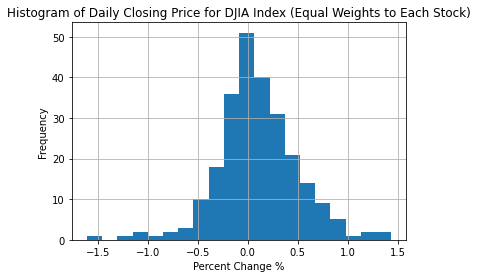

In [172]:
returns_diff.sum(axis=1).divide(30).hist(bins=20)
plt.title('Histogram of Daily Closing Price for DJIA Index (Equal Weights to Each Stock)')
plt.xlabel('Percent Change %')
plt.ylabel('Frequency');

In [173]:
tmp_df = returns_diff.sum(axis=1).divide(30)

tmp_ = ceil(len(tmp_df)*0.05)
tmp_ = tmp_df.sort_values().head(tmp_)
tmp_.describe()

count    13.000000
mean     -0.836811
std       0.347405
min      -1.610578
25%      -1.063653
50%      -0.749778
75%      -0.561000
max      -0.518672
dtype: float64

Above is a description of the bottom 5% of returns for DJIA.

# Parametric Method for Calculating VaR - Dow Jones Industrial Average

The parametric method VAR (also known as Variance/Covariance VAR) calculation is a popular method for assessing a portfolios Value at Risk because the only variables you need to do the calculation are the mean and standard deviation of the portfolio. Below we start with a function to take the `returns_diff` dataframe and return a dictionary with values of mean and standard deviation for percentage change of daily closing price for each component in the DJIA.

In [239]:
def mean_std(data: pd.DataFrame) -> dict:
    DOW_MS = {} #mean and standard deviation
    for n in data.columns:
        diff_mean = data[n].mean()
        diff_std = data[n].std()
        DOW_MS[n] = (diff_mean, diff_std)
    return DOW_MS

In [240]:
DOW_mean_std = mean_std(returns_diff)

In [241]:
DOW_MS_df = pd.DataFrame.from_dict(DOW_mean_std, orient='index').rename(columns={0:'Average',1:'Standard Deviation'})

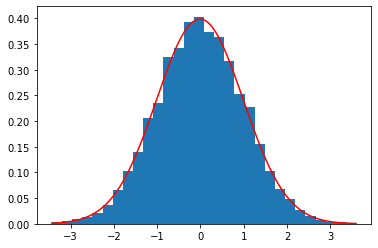

In [207]:
plt.plot(np.sort(gaussian),sc.stats.norm.pdf(np.sort(gaussian), gaussian.mean(), gaussian.std()), "r" )
plt.hist(gaussian,bins=30, density=True)
plt.show();

We now use this dataframe and `scipy.stats.norm` module for its probability density function `pdf()` and plot these values along with a histogram of the `returns_diff` dataframe for each stock in the Dow Jones Industrial Average to give us a visual represenation of each stocks volatility.

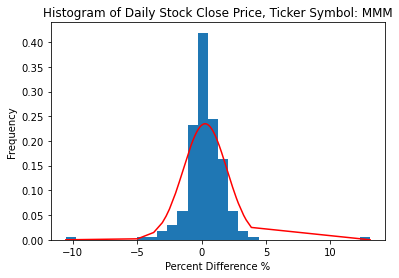

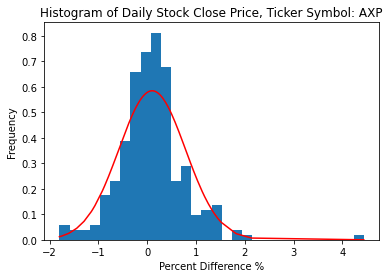

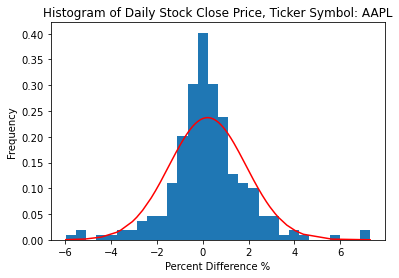

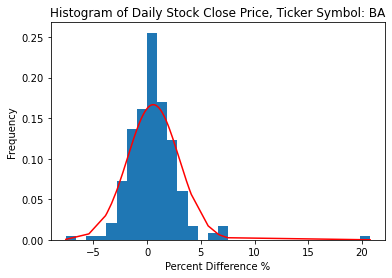

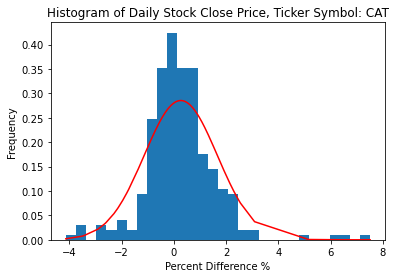

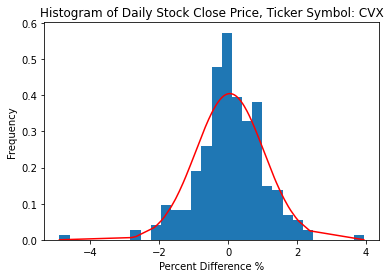

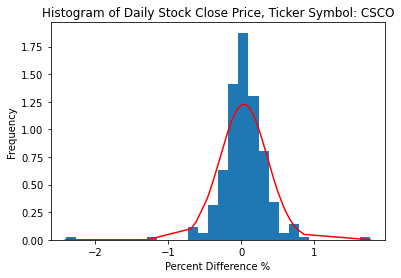

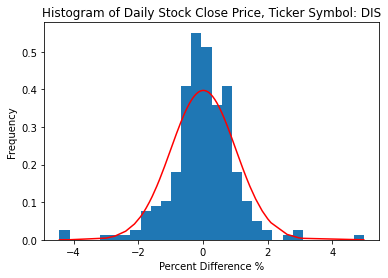

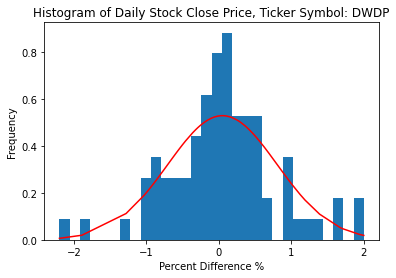

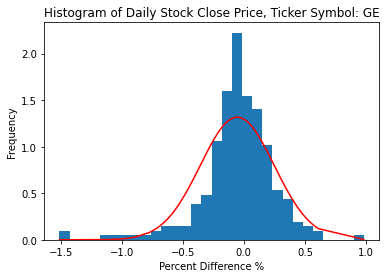

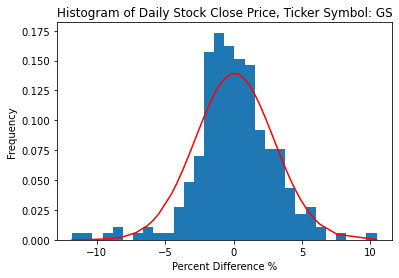

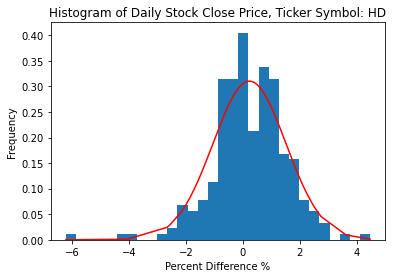

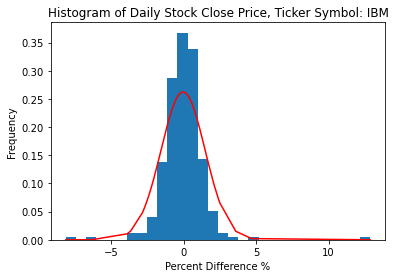

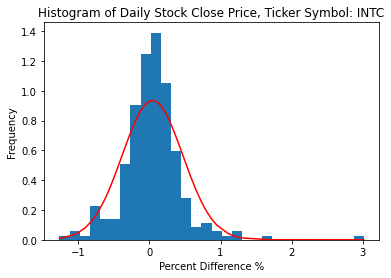

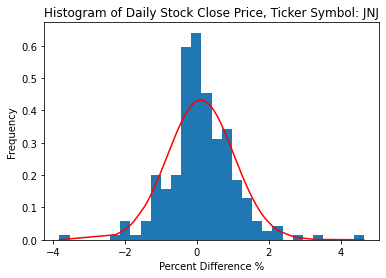

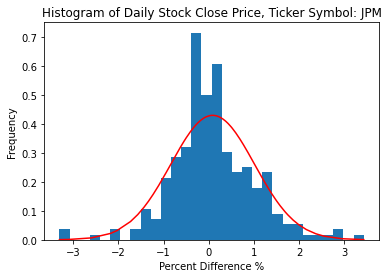

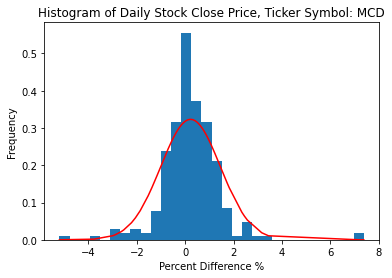

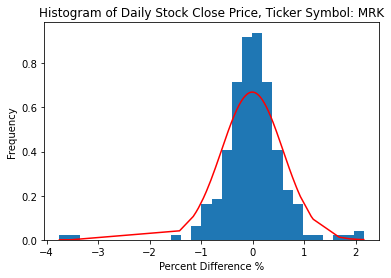

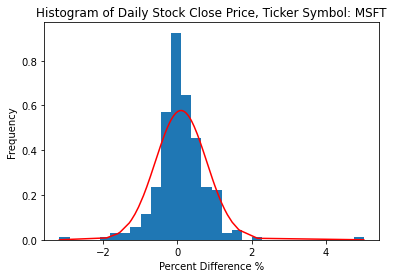

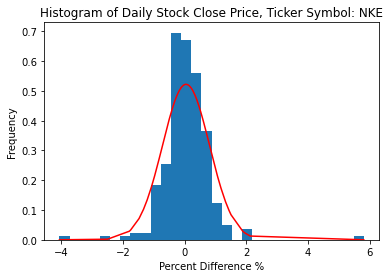

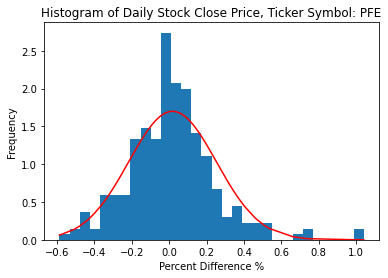

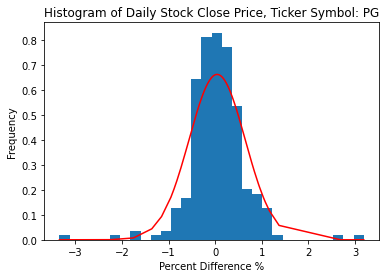

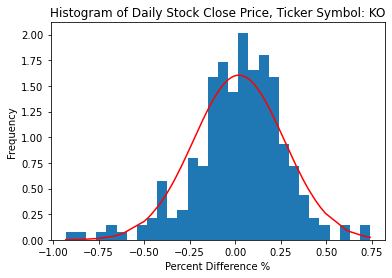

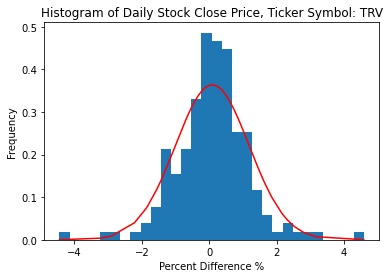

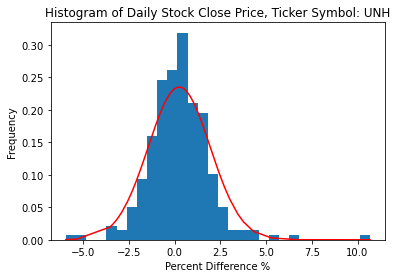

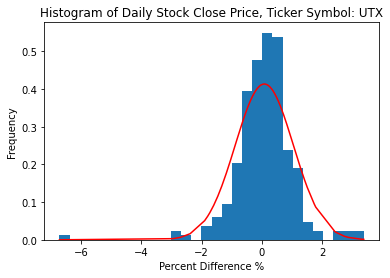

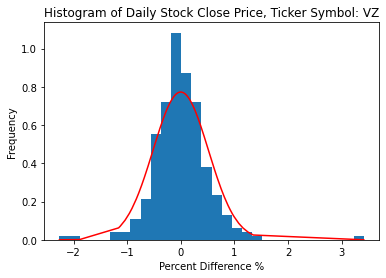

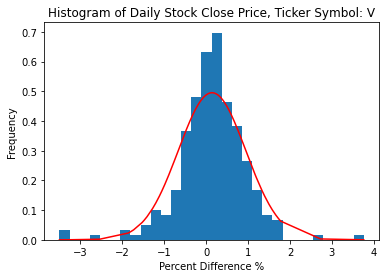

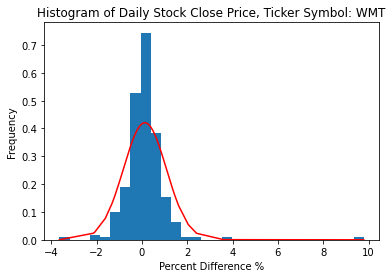

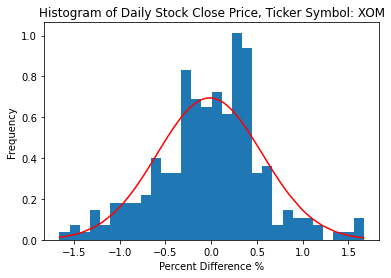

In [213]:
for n in returns_diff.columns:
    tmp_ = returns_diff[n].dropna().sort_values()
    ave_ = DOW_MS_df.loc[n,'Average']
    std_ = DOW_MS_df.loc[n,'Standard Deviation']
    plt.plot(tmp_, sc.stats.norm.pdf(tmp_, ave_, std_), "r" )
    plt.hist(returns_diff[n],bins=30, density=True)
    plt.title('Histogram of Daily Stock Close Price, Ticker Symbol: ' + n)
    plt.xlabel('Percent Difference %')
    plt.ylabel('Frequency')
    plt.show();

## Compare Parametric VaR to Historic VaR

Looking at the first five stocks (in alphabetic order) we will look at how the parametric version for calculating Value at Risk (also known as Variance-Covariance method) to the historic method above.

In [225]:
ticker_ = 'MMM'
ave_ = DOW_MS_df.loc[ticker_,'Average']
std_ = DOW_MS_df.loc[ticker_,'Standard Deviation']
parametric = sc.stats.norm.ppf(1-0.95, loc=ave_, scale=std_)
parametric = round(parametric, 2)
print('The minimum value one can expect to lose for one-day 5% VaR using the parametric method is {}'.format(parametric))

The minimum value one can expect to lose for one-day 5% VaR using the parametric method is -2.52


In [223]:
min_ = DOW_VaR_df.loc[ticker_,'Minimum']
min_ = round(min_, 2)
max_ = DOW_VaR_df.loc[ticker_,'Maximum']
max_ = round(max_, 2)
print('The range for one-day 5% VaR for '+ticker_+' is from {} to {}'.format(min_,max_))

The range for one-day 5% VaR for MMM is from -1.91 to -10.55


In [227]:
for n in returns_diff.columns:
    ticker_ = n
    ave_ = DOW_MS_df.loc[ticker_,'Average']
    std_ = DOW_MS_df.loc[ticker_,'Standard Deviation']
    parametric = sc.stats.norm.ppf(1-0.95, loc=ave_, scale=std_)
    parametric = round(parametric, 2)
    print('The minimum value one can expect to lose for one-day 5% VaR using the parametric method is {}'.format(parametric))

    min_ = DOW_VaR_df.loc[ticker_,'Minimum']
    min_ = round(min_, 2)
    max_ = DOW_VaR_df.loc[ticker_,'Maximum']
    max_ = round(max_, 2)
    print('The range for one-day 5% VaR for '+ticker_+' is from {} to {}'.format(min_,max_))
    print('\n')

The minimum value one can expect to lose for one-day 5% VaR using the parametric method is -2.52
The range for one-day 5% VaR for MMM is from -1.91 to -10.55


The minimum value one can expect to lose for one-day 5% VaR using the parametric method is -1.02
The range for one-day 5% VaR for AXP is from -0.9 to -1.8


The minimum value one can expect to lose for one-day 5% VaR using the parametric method is -2.56
The range for one-day 5% VaR for AAPL is from -2.63 to -5.99


The minimum value one can expect to lose for one-day 5% VaR using the parametric method is -3.37
The range for one-day 5% VaR for BA is from -2.43 to -7.57


The minimum value one can expect to lose for one-day 5% VaR using the parametric method is -2.03
The range for one-day 5% VaR for CAT is from -1.95 to -4.13


The minimum value one can expect to lose for one-day 5% VaR using the parametric method is -1.58
The range for one-day 5% VaR for CVX is from -1.66 to -4.9


The minimum value one can expect to lose for one

In [ ]:
def compareVaR(data: pd.DataFrame) -> dict:
    DOW_MS = {} #mean and standard deviation
    for n in data.columns:
        diff_mean = data[n].mean()
        diff_std = data[n].std()
        DOW_MS[n] = (diff_mean, diff_std)
    return DOW_MS
DOW_mean_std = mean_std(returns_diff)
DOW_MS_df = pd.DataFrame.from_dict(DOW_mean_std, orient='index').rename(columns={0:'Average',1:'Standard Deviation'})

In [385]:
def compareVaR(data: pd.DataFrame) -> dict:
    DOW_compare_ = {} #mean and standard deviation
    for n in data.columns:
        ave_ = DOW_MS_df.loc[n,'Average']
        std_ = DOW_MS_df.loc[n,'Standard Deviation']
        parametric = sc.stats.norm.ppf(1-0.95, loc=ave_, scale=std_)
        parametric = round(parametric, 2)

        min_ = DOW_VaR_df.loc[n,'Minimum']
        min_ = round(min_, 2)
        DOW_compare_[n] = (min_, parametric)
    return DOW_compare_

DOW_compare = compareVaR(returns_diff)
DOW_compare_df = pd.DataFrame.from_dict(DOW_compare, orient='index').rename(columns={0:'Min - Historic',1:'Min - Parametric'})

In [386]:
def highlight_min_row(s):
    is_min = s == s.min()
    return ['background-color: red' if cell else '' for cell in is_min]

In [392]:
DOW_compare_df.T.style.apply(highlight_min_row)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,DIS,DWDP,GE,GS,HD,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PFE,PG,KO,TRV,UNH,UTX,VZ,V,WMT,XOM
Min - Historic,-1.910000,-0.900000,-2.630000,-2.430000,-1.950000,-1.660000,-0.390000,-1.620000,-0.990000,-0.590000,-4.180000,-1.910000,-1.860000,-0.650000,-1.240000,-1.330000,-1.410000,-0.820000,-0.880000,-1.000000,-0.360000,-0.740000,-0.410000,-1.500000,-2.180000,-1.330000,-0.710000,-1.160000,-0.980000,-1.040000
Min - Parametric,-2.520000,-1.020000,-2.560000,-3.370000,-2.030000,-1.580000,-0.500000,-1.640000,-1.190000,-0.550000,-4.660000,-1.880000,-2.530000,-0.660000,-1.410000,-1.440000,-1.810000,-0.990000,-1.040000,-1.210000,-0.370000,-0.950000,-0.390000,-1.720000,-2.550000,-1.510000,-0.850000,-1.190000,-1.430000,-0.960000


In [400]:
ratio_ = 0
for n in returns_diff.columns:
    hist_ = DOW_compare_df.loc[n,'Min - Historic']
    para_ = DOW_compare_df.loc[n,'Min - Parametric']
    if hist_ > para_:
        ratio_ += 1

print('This Parametric VaR is calculated to be lower {} times out of {}'.format(ratio_, len(DOW_compare_df)))

This Parametric VaR is calculated to be lower 24 times out of 30


We note that the Parametric Value at Risk calculation estimates a larger loss 80% of the time.